<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/master/13.ResNet/ResNet18_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Super Convergence using ResNet18
In this notebook, will modify the code in the link [CIFAR-10 - 92% Acc within 10 Epochs](https://mc.ai/tutorial-1-cifar10-with-google-colabs-free-gpu%E2%80%8A-%E2%80%8A92-5/) as below and target 90% accuracy or more

*   Use ResNet18 model instead
*   Model must look like Conv->B1->B2->B3->B4 and not individually called Convs.
*   Batch Size 128
*   Use Normalization values of: (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
*   Random Crop of 32 with padding of 4px
*   Horizontal Flip (0.5)
*   Optimizer: SGD, Weight-Decay: 5e-4
*   NOT-OneCycleLR
*   Train for 300 Epochs




In [0]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe
import datetime as dt

## Eager Execution
Uses Eager execution runtime. More details on Eager Execution:

https://github.com/gkdivya/EVA/blob/master/12.SuperConvergence/EagerExecution.md




In [0]:
tf.enable_eager_execution()

In [0]:
BATCH_SIZE = 128 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 300 #@param {type:"integer"}

## Initializing weights

**Initialization of Convolution layer**

For initializing weights in Convolution layer, Keras uses `Xavier Glorot init` weight initialization algorithm and PyTorch uses a different version of `Kaiming He init`. Since we are trying to replicate DavidNet's PyTorch version code in Keras, we are initializing the weights same as what is been implemented in PyTorch.

PyTorch takes the inverse square root of the layer’s fan-in as a bound, and then generates a random initial weight in the range [-bound, bound]

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [12]:
norms = np.array([0.4914, 0.4822, 0.4465])
stds = np.array([0.2023, 0.1994, 0.2010])

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

def normalize_img(img):
  img = img/255
  img = img - norms
  img = img/stds
  return img

def pad_img(img):
  return np.pad(img, ((4,4),(4,4),(0,0)), mode='constant',)

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

def random_crop(x, random_crop_size):
    w, h = x.shape[0], x.shape[1]
    rangew = (w - random_crop_size[0]) // 2
    rangeh = (h - random_crop_size[1]) // 2
    offsetw = 0 if rangew == 0 else np.random.randint(rangew)
    offseth = 0 if rangeh == 0 else np.random.randint(rangeh)
    return x[offsetw:offsetw+random_crop_size[0], offseth:offseth+random_crop_size[1],:]
  
#cutout_fn = get_random_eraser(p=cutout_proba, s_l=0.1, s_h=0.3, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=max_erasures_per_image, pixel_level=True)


  
def reg_fn(x):
  x = pad_img(x)
  x = random_crop(x,[32,32])
  #x = cutout_fn(x)
  return x

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
x_test = np.array(list(map(normalize_img,x_test)))
x_train = np.array(list(map(normalize_img,x_train)))

datagen = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,featurewise_std_normalization=False,
                           preprocessing_function=reg_fn,horizontal_flip=True)
datagen.fit(x_train)

datagen_validation = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,featurewise_std_normalization=False,)


train_iterator = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE,shuffle=True)
_ = next(train_iterator)

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(64).shuffle(10000)
train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
train_dataset = train_dataset.map(lambda x, y: (tf.image.central_crop(x, 0.75), y))
train_dataset = train_dataset.map(lambda x, y: (tf.image.random_flip_left_right(x), y))
train_dataset = train_dataset.repeat()

In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(5000).shuffle(10000)
valid_dataset = valid_dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
valid_dataset = valid_dataset.map(lambda x, y: (tf.image.central_crop(x, 0.75), y))
valid_dataset = valid_dataset.repeat()

In [0]:
def res_net_block(input_data, filters, conv_size):
  x = tf.keras.layers.Conv2D(filters, conv_size, activation='relu', padding='same')(input_data)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(filters, conv_size, activation=None, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Add()([x, input_data])
  x = tf.keras.layers.Activation('relu')(x)
  return x

In [0]:
callbacks = [
  # Write TensorBoard logs to `./logs` directory
  tf.keras.callbacks.TensorBoard(log_dir='./log/{}'.format(dt.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")), write_images=True),
]

In [0]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Conv2D(32, 3, activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(3)(x)

num_res_net_blocks = 4 # ResNet18 have 4 blocks
for i in range(num_res_net_blocks):
  x = res_net_block(x, 64, 3)

x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#x = tf.keras.layers.Dense(256, activation='relu')(x)
#x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

res_net_model = tf.keras.Model(inputs, outputs)

In [36]:
res_net_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
res_net_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 30, 30, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 28, 28, 64)   18496       conv2d_22[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 9, 9, 64)     0           conv2d_23[0][0]                  
____________________________________________________________________________________________

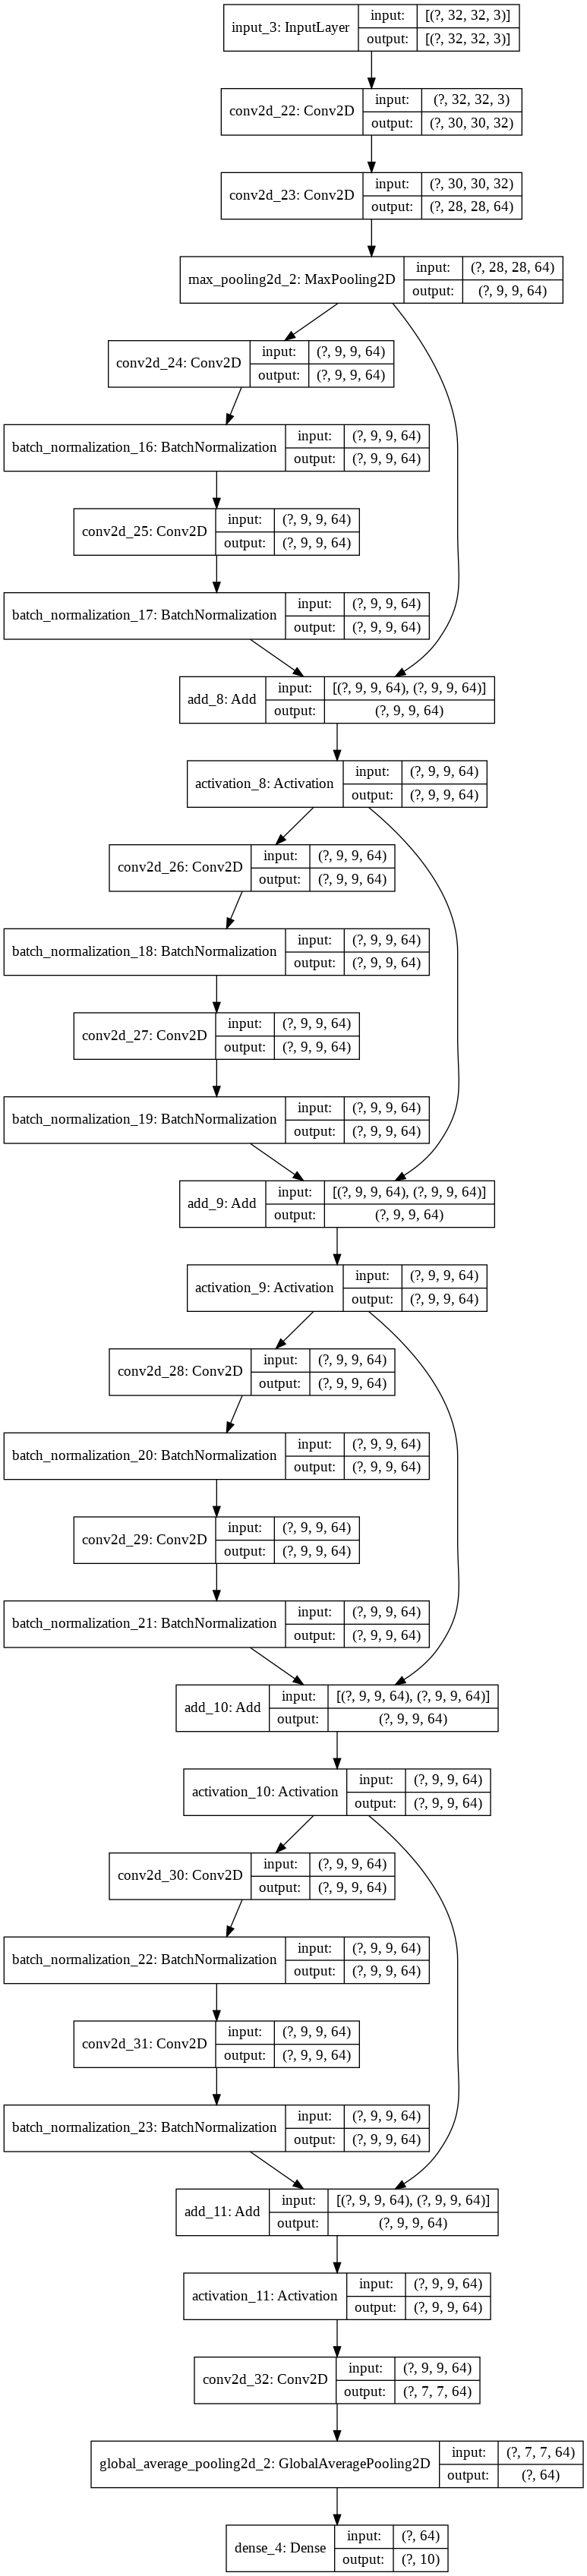

In [37]:
tf.keras.utils.plot_model(res_net_model, show_shapes=True  ,to_file='model.png')

In [38]:
res_net_model.fit(train_dataset, epochs=30, steps_per_epoch=195,
          validation_data=valid_dataset,
          validation_steps=3, callbacks=callbacks)

Train for 195 steps, validate for 3 steps


NotFoundError: ignored

In [0]:
#from CLR.clr_callback import *
class LR_Finder(tf.keras.callbacks.Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        print("self.lr_mult", self.lr_mult)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        tf.keras.backend.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
                
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
                
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            print(" LOSS EXPLODING")
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        print(" LR", lr)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)        
        
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])
        
    def plot_losses(self, n_skip=10):
        plt.rcParams["figure.figsize"] = (10, 5)
        plt.subplot(1, 2, 1)
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
        plt.subplot(1, 2, 2)         
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')

In [41]:
train_steps = len(x_train)
test_steps = len(x_test)
lr_finder = LR_Finder(start_lr=1e-4, end_lr=1e-1, step_size=train_steps)

res_net_model.fit_generator(train_iterator, steps_per_epoch=len(x_train), epochs=1, callbacks = [lr_finder])

self.lr_mult 1.0001381646494358
 LR 0.00010001381646494359
   70/50000 [..............................] - ETA: 1:08:07 - loss: 0.8980 - acc: 0.6875

KeyboardInterrupt: ignored